In [ ]:
from google.colab import files
uploaded = files.upload()

Saving actions_data.csv to actions_data (2).csv


# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:
import csv
from collections import Counter
import re

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def generate_ngrams(words, n):
    return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]

def calculate_ngram_frequencies(texts, n):
    ngram_counter = Counter()
    for text in texts:
        words = tokenize(text)
        ngrams = generate_ngrams(words, n)
        ngram_counter.update(ngrams)
    return ngram_counter

def calculate_bigram_probabilities(bigram_counts, unigram_counts):
    probabilities = {}
    for (w1, w2), count in bigram_counts.items():
        probabilities[(w1, w2)] = count / unigram_counts.get(w1, 1)  # Avoid division by zero
    return probabilities

def extract_noun_phrases(texts):
    noun_phrases = Counter()
    for text in texts:
        # Find sequences of capitalized words (may miss some noun phrases)
        phrases = re.findall(r'\b(?:[A-Z][a-z]*\s?)+\b', text)
        noun_phrases.update(phrases)
    return noun_phrases

def calculate_relative_probabilities(noun_phrases):
    max_freq = max(noun_phrases.values(), default=1)
    return {phrase: freq / max_freq for phrase, freq in noun_phrases.items()}

def print_noun_phrase_table(relative_probabilities):
    print("\nNoun Phrase Probabilities Table:")
    print("{:<30} {:<10}".format("Noun Phrase", "Probability"))
    print("-" * 40)
    for phrase, prob in sorted(relative_probabilities.items(), key=lambda x: -x[1]):
        print("{:<30} {:.4f}".format(phrase, prob))

def main():
    texts = []
    try:
        with open('tweets.csv', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            if 'clean_text' not in reader.fieldnames:
                raise ValueError("CSV file missing 'clean_text' column")
            texts = [row['clean_text'] for row in reader]
    except FileNotFoundError:
        print("Error: 'tweets.csv' file not found.")
        return

    bigram_counts = calculate_ngram_frequencies(texts, 2)
    trigram_counts = calculate_ngram_frequencies(texts, 3)
    unigram_counts = calculate_ngram_frequencies(texts, 1)
    bigram_probabilities = calculate_bigram_probabilities(bigram_counts, unigram_counts)
    noun_phrases = extract_noun_phrases(texts)
    relative_probabilities = calculate_relative_probabilities(noun_phrases)

    print("Bigram Counts:", bigram_counts)
    print("Trigram Counts:", trigram_counts)
    print("Bigram Probabilities:", bigram_probabilities)
    print_noun_phrase_table(relative_probabilities)

if __name__ == "__main__":
    main()

Bigram Counts: Counter({('ai', 'machinelearning'): 18, ('are', 'you'): 15, ('you', 'ready'): 14, ('rt', 'the'): 13, ('cybersecurity', 'cyberattack'): 12, ('bigdata', 'analytics'): 12, ('the', 'only'): 12, ('only', 'way'): 12, ('way', 'to'): 12, ('to', 'win'): 12, ('win', 'is'): 12, ('is', 'to'): 12, ('to', 'play'): 12, ('play', 'better'): 12, ('better', 'than'): 12, ('than', 'the'): 12, ('the', 'others'): 12, ('others', 'heroesai'): 12, ('heroesai', 'ai'): 12, ('ai', 'crypto'): 12, ('crypto', 'is'): 12, ('is', 'shaping'): 12, ('shaping', 'the'): 12, ('the', 'new'): 12, ('new', 'economy'): 12, ('economy', 'are'): 12, ('your', 'account'): 11, ('analytics', 'datascience'): 11, ('datascience', 'ai'): 10, ('machinelearning', 'iot'): 10, ('iot', 'iiot'): 10, ('machinelearning', 'datascience'): 8, ('machine', 'learning'): 8, ('it', 's'): 7, ('of', 'ai'): 7, ('read', 'more'): 7, ('by', 'robotics'): 6, ('ai', 'artificialintelligence'): 6, ('is', 'a'): 6, ('now', 'for'): 6, ('hacked', 'icloud'):

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [ ]:
import math
import csv
from collections import defaultdict, Counter

def load_data(file_path):
    documents = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            documents.append(row['clean_text'])
    return documents

def compute_tf(doc):
    words = doc.split()
    word_count = Counter(words)
    total_words = len(words)
    return {word: count / total_words for word, count in word_count.items()}

def compute_idf(docs):
    N = len(docs)
    word_doc_count = defaultdict(int)
    for doc in docs:
        unique_words = set(doc.split())
        for word in unique_words:
            word_doc_count[word] += 1
    return {word: math.log(N / (count + 1)) for word, count in word_doc_count.items()}

def compute_tf_idf(docs):
    idf = compute_idf(docs)
    tf_idf_matrix = []
    for doc in docs:
        tf = compute_tf(doc)
        tf_idf_matrix.append({word: tf[word] * idf[word] for word in tf})
    return tf_idf_matrix

def cosine_similarity(vec1, vec2):
    dot_product = sum(vec1.get(word, 0) * vec2.get(word, 0) for word in set(vec1) | set(vec2))
    norm1 = math.sqrt(sum(val ** 2 for val in vec1.values()))
    norm2 = math.sqrt(sum(val ** 2 for val in vec2.values()))
    return dot_product / (norm1 * norm2) if norm1 and norm2 else 0

def rank_documents(query, docs):
    tf_idf_matrix = compute_tf_idf(docs)
    idf = compute_idf(docs)
    query_tf = compute_tf(query)
    query_vector = {word: query_tf[word] * idf.get(word, 0) for word in query_tf}
    rankings = [(i, cosine_similarity(query_vector, doc_vec)) for i, doc_vec in enumerate(tf_idf_matrix)]
    return rankings, tf_idf_matrix

if __name__ == "__main__":
    file_path = "tweets.csv"  # Adjust path if needed
    documents = load_data(file_path)

    # Compute the TF-IDF matrix and rank documents
    ranked_docs, tf_idf_matrix = rank_documents("AI education future innovation", documents)

    # Print the TF-IDF matrix for each document
    print("TF-IDF Matrix:")
    for i, doc_vec in enumerate(tf_idf_matrix):
        print(f"Document {i}:")
        for term, weight in doc_vec.items():
            print(f"  {term}: {weight:.4f}")

    # Print the ranked documents with cosine similarity scores
    print("\nRanked Documents:")
    # Sorting rankings in descending order of score
    for idx, score in sorted(ranked_docs, key=lambda x: x[1], reverse=True):
        print(f"Document {idx}: Score {score:.4f}")


TF-IDF Matrix:
Document 0:
  AI:: 0.1758
  Reshaping: 0.2445
  the: 0.0674
  Future: 0.2445
  of: 0.1038
  Teaching?: 0.2445
  AIinEducation: 0.2445
  EdTech: 0.2445
  ArtificialIntelligence: 0.0774
  FutureofEducation: 0.2445
  Teachers: 0.2445
  EducationTechnology: 0.2445
  AITeaching: 0.2445
  PersonalizedLearning: 0.2445
  EducationalInnovation: 0.2445
  SchoolTechnology: 0.2445
Document 1:
  RT: 0.0469
  :: 0.0456
  This: 0.1664
  14.8: 0.2173
  ft: 0.2173
  anime-style: 0.2173
  transformer: 0.2173
  robot: 0.2173
  can: 0.1092
  be: 0.1788
  piloted: 0.2173
  by: 0.2108
  a: 0.1018
  person: 0.2173
  Robotics: 0.1403
  AI: 0.0257
  ArtificialIntelli…: 0.2173
Document 2:
  KritiKal: 0.2608
  helps: 0.1304
  businesses: 0.1073
  to: 0.0360
  revolutionize: 0.1304
  application: 0.1304
  with: 0.0655
  AI: 0.0308
  &amp;: 0.0803
  GenAI-driven: 0.1304
  solutions,: 0.2608
  specializing: 0.1304
  in: 0.0536
  model: 0.1169
  integration,: 0.1304
  management,: 0.1304
  cloud: 0.11

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

Loaded 100 sentences.
Vocabulary size: 997
Training pairs: 9368
Epoch: 1 Total Loss: 64673.66552639106
Epoch: 2 Total Loss: 64636.09247275757
Epoch: 3 Total Loss: 64539.419672968164
Epoch: 4 Total Loss: 64211.0415862769
Epoch: 5 Total Loss: 63062.24753256953
Epoch: 6 Total Loss: 60841.99333696993
Epoch: 7 Total Loss: 58852.69969380362
Epoch: 8 Total Loss: 57440.233365092994
Epoch: 9 Total Loss: 56284.31957116013
Epoch: 10 Total Loss: 55213.954138638655


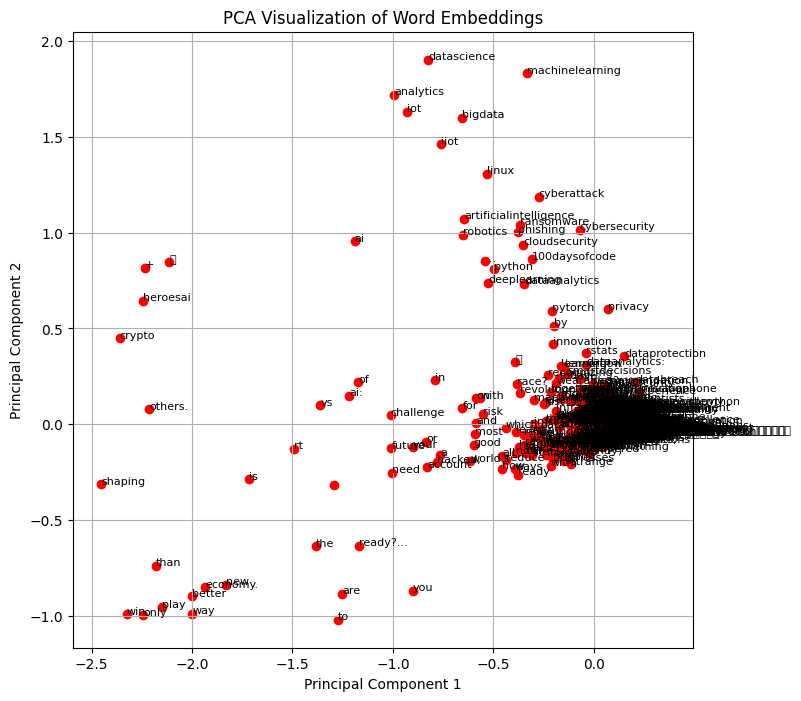

t-SNE iteration: 100
t-SNE iteration: 200
t-SNE iteration: 300
t-SNE iteration: 400
t-SNE iteration: 500


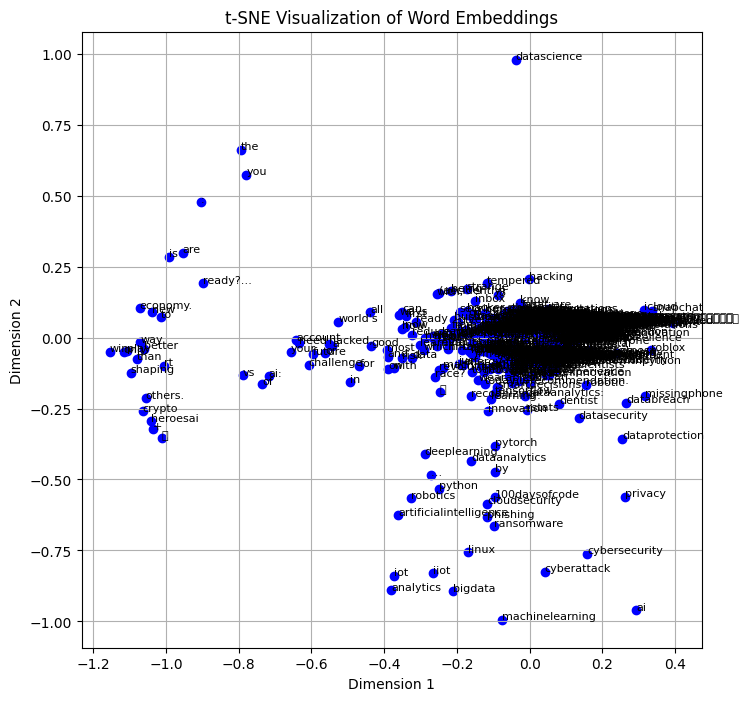


Cosine Similarities:
  ai vs artificialintelligence: 0.5118
  ai vs robotics: 0.6732
  education vs tech: 0.1827


In [ ]:
# Write your code here
import csv
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Loading & Preprocessing
# Read the tweets.csv file and extract the clean text
def load_data(filename):
    sentences = []
    with open(filename, newline='', encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            text = row['clean_text']
            if text:
                # lowercase and simple whitespace tokenization
                tokens = text.lower().split()
                sentences.append(tokens)
    return sentences
# Build vocabulary mapping word -> index
def build_vocab(sentences):
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab
# Generate training pairs using a given window size (Skip-gram: center word -> context words)
def generate_training_data(sentences, window_size=2):
    training_data = []
    for sentence in sentences:
        for i, word in enumerate(sentence):
            # set window boundaries (neighbors)
            start = max(0, i - window_size)
            end = min(len(sentence), i + window_size + 1)
            for j in range(start, end):
                if j != i:
                    training_data.append((word, sentence[j]))
    return training_data
# 2. Training a Word Embedding Model
# Softmax function (numerically stable)
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Train Skip-gram model using full softmax
def train_skipgram(training_data, vocab, embedding_dim=300, learning_rate=0.01, n_epochs=10):
    V = len(vocab)  # vocabulary size
    # Initialize weight matrices with small random values:
    # W: shape (V, embedding_dim) gives the word embeddings.
    # W_prime: shape (embedding_dim, V) maps from hidden to output (context distribution)
    W = np.random.randn(V, embedding_dim) * 0.01
    W_prime = np.random.randn(embedding_dim, V) * 0.01

    # For multiple epochs over the data
    for epoch in range(n_epochs):
        total_loss = 0
        # Loop over each training pair (center, context)
        for center_word, context_word in training_data:
            i = vocab[center_word]  # center word index
            j = vocab[context_word] # context word index

            # Forward pass: hidden representation = embedding of center word
            hidden = W[i].copy()  # shape (embedding_dim,)
            # Compute scores for all words: (embedding_dim,) dot (embedding_dim,V) => (V,)
            scores = np.dot(hidden, W_prime)
            # Compute probability distribution with softmax
            p = softmax(scores)
            # Loss: negative log likelihood of the true context word
            loss = -np.log(p[j] + 1e-8)
            total_loss += loss

            # Backward pass: compute gradients
            # For the softmax, the error is p with 1 subtracted at the true context index
            error = p.copy()
            error[j] -= 1  # derivative of cross-entropy loss

            # Gradients:
            # Gradient for W_prime: outer product (hidden vector and error vector)
            grad_W_prime = np.outer(hidden, error)  # shape (embedding_dim,V)
            # Gradient for the center word embedding: W_prime dot error
            grad_hidden = np.dot(W_prime, error)      # shape (embedding_dim,)

            # Update weights with gradient descent
            W_prime -= learning_rate * grad_W_prime
            W[i] -= learning_rate * grad_hidden

        print("Epoch:", epoch+1, "Total Loss:", total_loss)
    return W, W_prime

# 3. Visualization – PCA and t-SNE
# PCA implementation from scratch
def pca(X, n_components=2):
    # Center data (subtract mean)
    X_centered = X - np.mean(X, axis=0)
    # Compute covariance matrix
    cov = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)
    # Eigen decomposition (note: np.linalg.eigh works for symmetric matrices)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Sort eigenvectors in descending order by eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Project data onto the top components
    X_reduced = np.dot(X_centered, eigenvectors[:, :n_components])
    return X_reduced

# A very t-SNE implementation
def compute_high_dim_affinities(X, sigma=1.0):
    n = X.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                diff = X[i] - X[j]
                P[i, j] = np.exp(-np.sum(diff**2) / (2 * sigma**2))
        # Normalize row
        row_sum = np.sum(P[i])
        if row_sum > 0:
            P[i] /= row_sum
    # Symmetrize and normalize P (as in t-SNE)
    P = (P + P.T) / (2 * n)
    return P

def compute_low_dim_affinities(Y):
    n = Y.shape[0]
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                diff = Y[i] - Y[j]
                Q[i, j] = 1 / (1 + np.sum(diff**2))
    sum_Q = np.sum(Q)
    Q = Q / sum_Q if sum_Q != 0 else Q
    return Q

def tsne_gradient(P, Y, Q):
    n, dim = Y.shape
    dY = np.zeros_like(Y)
    for i in range(n):
        for j in range(n):
            if i != j:
                diff = Y[i] - Y[j]
                # The gradient factor (using the t-distribution kernel)
                factor = (P[i, j] - Q[i, j]) * (1 / (1 + np.sum(diff**2)))
                dY[i] += 4 * factor * diff
    return dY

def tsne(X, no_dims=2, sigma=1.0, n_iter=500, learning_rate=100):
    n = X.shape[0]
    # Initialize low-dimensional map with small random values
    Y = np.random.randn(n, no_dims) * 0.0001
    P = compute_high_dim_affinities(X, sigma)
    # Iterative gradient descent
    for iter in range(n_iter):
        Q = compute_low_dim_affinities(Y)
        dY = tsne_gradient(P, Y, Q)
        Y -= learning_rate * dY
        if (iter + 1) % 100 == 0:
            print("t-SNE iteration:", iter+1)
    return Y
# 4. Cosine Similarity Function
def cosine_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1 * norm2 + 1e-8)
# Main execution
# Load and preprocess data
sentences = load_data("tweets.csv")
print("Loaded", len(sentences), "sentences.")
vocab = build_vocab(sentences)
print("Vocabulary size:", len(vocab))
training_data = generate_training_data(sentences, window_size=2)
print("Training pairs:", len(training_data))
# Train the word embedding model
embedding_dim = 300
W, _ = train_skipgram(training_data, vocab, embedding_dim=embedding_dim, learning_rate=0.01, n_epochs=10)
# Now each row of W is the 300-dimensional embedding for the corresponding word

# List words
words = list(vocab.keys())
embeddings = np.array([W[vocab[word]] for word in words])
# 4a. Visualize using PCA
embeddings_pca = pca(embeddings, n_components=2)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='red')
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_pca[i, 0], embeddings_pca[i, 1]), fontsize=8)
plt.title("PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# 4b. Visualize using t-SNE (using our simplified implementation)
embeddings_tsne = tsne(embeddings, no_dims=2, sigma=1.0, n_iter=500, learning_rate=100)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c='blue')
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), fontsize=8)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
# 5. Calculate cosine similarity between selected word pairs
word_pairs = [
    ("ai", "artificialintelligence"),
    ("ai", "robotics"),
    ("education", "tech")
]
print("\nCosine Similarities:")
for w1, w2 in word_pairs:
    if w1 in vocab and w2 in vocab:
        vec1 = W[vocab[w1]]
        vec2 = W[vocab[w2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"  {w1} vs {w2}: {sim:.4f}")
    else:
        print(f"  One or both words '{w1}' or '{w2}' are not in the vocabulary.")

## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



### **Chosen NLP Tasks:**
1. **Sentiment Analysis** – The dataset is labeled with sentiments (Positive, Negative, Neutral), so it can be used to train a model to classify the sentiment of new text inputs.
---
### **Labeling Schema Used:**
Each review is annotated with one of three sentiment categories based on its meaning:

1. **Positive** – Reviews expressing satisfaction, happiness, or appreciation.

2. **Negative** – Reviews indicating dissatisfaction, frustration, or disappointment.

3. **Neutral** – Reviews that are neither clearly positive nor negative, often mixed or indifferent.

In [ ]:
# The GitHub link of your final csv file


# Link:https://github.com/Vamshi4243/Vamshi_INFO5731_Spring2025/blob/main/sentiment_data.csv



# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
"""I found the assignment quite interesting, especially the problem-solving aspects.
However, I struggled a bit with managing my time effectively because some parts took longer than expected.
I enjoyed how each task challenged me to think critically and apply what I have learned.
The time given was decent, but an extra day would have been helpful to refine my work.
"""

'I found the assignment quite interesting, especially the problem-solving aspects. \nHowever, I struggled a bit with managing my time effectively because some parts took longer than expected. \nI enjoyed how each task challenged me to think critically and apply what I have learned. \nThe time given was decent, but an extra day would have been helpful to refine my work. \n'